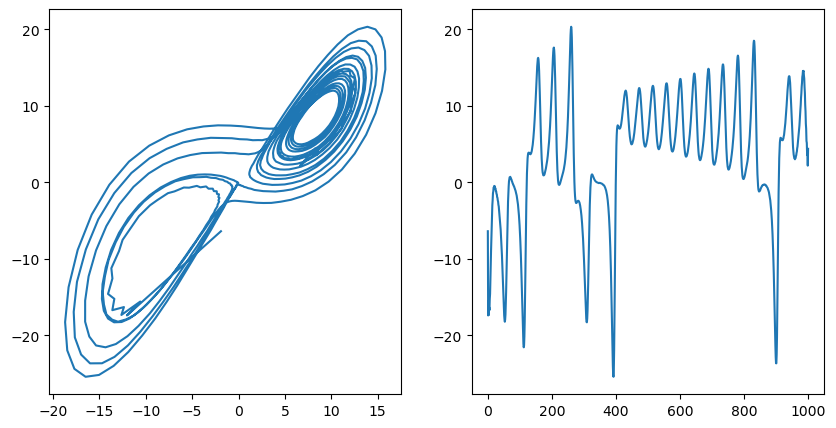

In [84]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True, noise=0.01)

sol += np.random.normal(0, 0.0, sol.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sol[:, 0], sol[:, 1])
ax[1].plot(sol[:, 1])

In [69]:
import torch


def embed_signal_torch(data, n_delays, delay_interval=1):
    """
    Create a delay embedding from the provided tensor data.

    Parameters
    ----------
    data : torch.tensor
        The data from which to create the delay embedding. Must be either: (1) a
        2-dimensional array/tensor of shape T x N where T is the number
        of time points and N is the number of observed dimensions
        at each time point, or (2) a 3-dimensional array/tensor of shape
        K x T x N where K is the number of "trials" and T and N are
        as defined above.

    n_delays : int
        Parameter that controls the size of the delay embedding. Explicitly,
        the number of delays to include.

    delay_interval : int
        The number of time steps between each delay in the delay embedding. Defaults
        to 1 time step.
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    device = data.device

    if data.shape[int(data.ndim == 3)] - (n_delays - 1) * delay_interval < 1:
        raise ValueError(
            "The number of delays is too large for the number of time points in the data!"
        )

    # initialize the embedding
    if data.ndim == 3:
        embedding = torch.zeros(
            (
                data.shape[0],
                data.shape[1] - (n_delays - 1) * delay_interval,
                data.shape[2] * n_delays,
            )
        ).to(device)
    else:
        embedding = torch.zeros(
            (data.shape[0] - (n_delays - 1) * delay_interval, data.shape[1] * n_delays)
        ).to(device)

    for d in range(n_delays):
        index = (n_delays - 1 - d) * delay_interval
        ddelay = d * delay_interval

        if data.ndim == 3:
            ddata = d * data.shape[2]
            embedding[:, :, ddata : ddata + data.shape[2]] = data[
                :, index : data.shape[1] - ddelay
            ]
        else:
            ddata = d * data.shape[1]
            embedding[:, ddata : ddata + data.shape[1]] = data[
                index : data.shape[0] - ddelay
            ]

    return embedding

In [76]:
n_delays = 7
delay_interval = 1


H = embed_signal_torch(sol[:, 0:1], n_delays, delay_interval)

U, S, V = torch.svd(H.T)

V = V.cpu().numpy()
plt.plot(V[:, 0], V[:, 1])

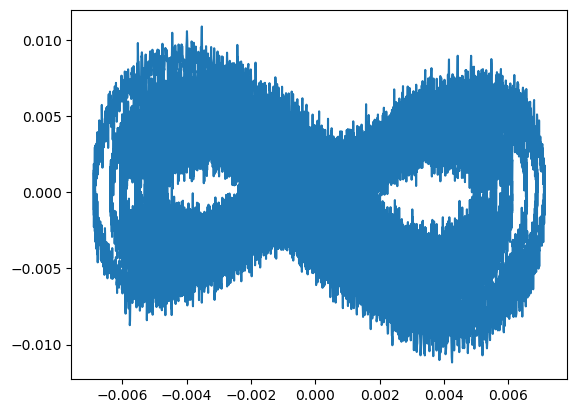

In [77]:
plt.plot(V[:, 0], V[:, 1])